<a href="https://colab.research.google.com/github/babymlin/Imbalanced_Anomaly-Detection/blob/main/ECG_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, utils, callbacks, metrics
import cv2

In [2]:
url = 'https://drive.google.com/file/d/1_OV0-zIKu4GlbDh_R1HBKeZx4fBO56Mn/view?usp=sharing'
!gdown --id 1_OV0-zIKu4GlbDh_R1HBKeZx4fBO56Mn --output mitbth.csv
df = pd.read_csv("mitbth.csv", header=None)
num_classes=5

Downloading...
From: https://drive.google.com/uc?id=1_OV0-zIKu4GlbDh_R1HBKeZx4fBO56Mn
To: /content/mitbth.csv
5.31MB [00:00, 46.6MB/s]


In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.924866,0.992844,0.536673,0.182469,0.094812,0.051878,0.035778,0.060823,0.093023,0.187835,0.339893,0.427549,0.472272,0.474061,0.413238,0.470483,0.475850,0.468694,0.447227,0.447227,0.447227,0.431127,0.398927,0.397138,0.415027,0.389982,0.350626,0.364937,0.381038,0.381038,0.363148,0.388193,0.407871,0.438283,0.454383,0.479428,0.474061,0.499106,0.520572,0.513417,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.981324,0.964346,0.414261,0.005093,0.139219,0.293718,0.302207,0.288625,0.280136,0.276740,0.283531,0.290323,0.283531,0.280136,0.281834,0.292020,0.290323,0.285229,0.292020,0.298812,0.298812,0.293718,0.292020,0.305603,0.300509,0.295416,0.302207,0.302207,0.302207,0.303905,0.308998,0.315789,0.315789,0.317487,0.319185,0.331070,0.336163,0.336163,0.339559,0.346350,...,0.302207,0.295416,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.985486,0.804064,0.438316,0.158200,0.014514,0.074020,0.121916,0.088534,0.078374,0.092888,0.082729,0.068215,0.071118,0.075472,0.082729,0.088534,0.088534,0.100145,0.121916,0.133527,0.169811,0.197388,0.220610,0.252540,0.283019,0.325109,0.346880,0.361393,0.383164,0.397678,0.403483,0.396226,0.375907,0.370102,0.349782,0.330914,0.320755,0.297533,0.283019,0.264151,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.827320,0.755155,0.520619,0.271907,0.123711,0.059278,0.030928,0.001289,0.000000,0.039948,0.144330,0.244845,0.291237,0.311856,0.322165,0.362113,0.407216,0.442010,0.475515,0.501289,0.518041,0.530928,0.559278,0.590206,0.606959,0.644330,0.657216,0.690722,0.713918,0.747423,0.764175,0.786082,0.789948,0.798969,0.797680,0.788660,0.771907,0.759021,0.722938,0.695876,...,0.862113,0.608247,0.568299,0.565722,0.534794,0.502577,0.48067,0.45232,0.426546,0.417526,0.399485,0.393041,0.390464,0.385309,0.382732,0.386598,0.382732,0.378866,0.376289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.965517,0.620690,0.206897,0.187739,0.118774,0.009579,0.005747,0.095785,0.203065,0.258621,0.268199,0.273946,0.289272,0.293103,0.293103,0.302682,0.312261,0.312261,0.308429,0.316092,0.325671,0.329502,0.329502,0.340996,0.354406,0.356322,0.360153,0.371648,0.385057,0.394636,0.400383,0.421456,0.434866,0.452107,0.459770,0.471264,0.484674,0.492337,0.494253,0.503831,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_train, df_val = train_test_split(df, test_size=0.2)

In [5]:
x_train = df_train.iloc[:, :-1]
x_train = np.expand_dims(x_train, axis=-1)
y_train = df_train.iloc[:, -1]

x_val = df_val.iloc[:, :-1]
x_val = np.expand_dims(x_val, axis=-1)
y_val = df_val.iloc[:, -1]

y_train = utils.to_categorical(y_train, num_classes=num_classes)
y_val = utils.to_categorical(y_val, num_classes=num_classes)

In [6]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1751, 187, 1), (1751, 5), (438, 187, 1), (438, 5))

label:  [1. 0. 0. 0. 0.]


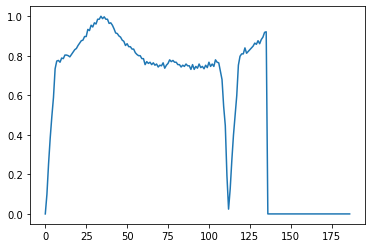

In [7]:
idx = 18
print('label: ', y_val[idx])
plt.plot(x_val[idx])

In [8]:
np.unique(np.argmax(y_train, axis=-1), return_counts=True), np.unique(np.argmax(y_val, axis=-1), return_counts=True)

((array([0, 1, 2, 3, 4]), array([1453,   52,  113,   15,  118])),
 (array([0, 1, 2, 3, 4]), array([369,  10,  22,   4,  33])))

In [9]:
def build_model():
    inputs = layers.Input(shape=x_train.shape[1:])
    conv1_1 = layers.Conv1D(64, (6), activation='relu')(inputs)
    conv1_1 = layers.BatchNormalization()(conv1_1)
    pool1 = layers.Conv1D(64, 3, strides=(2), padding="same")(conv1_1)
    conv2_1 = layers.Conv1D(128, (3), activation='relu')(pool1)
    conv2_1 = layers.BatchNormalization()(conv2_1)
    pool2 = layers.Conv1D(128, 3, strides=(2), padding="same")(conv2_1)
    conv3_1 = layers.Conv1D(256, (3), activation='relu')(pool2)
    conv3_1 = layers.BatchNormalization()(conv3_1)
    pool3 = layers.Conv1D(256, 3, strides=(2), padding="same")(conv3_1)
    pool3 = layers.MaxPooling1D()(pool3)
    flatten = layers.GlobalAveragePooling1D()(pool3)
    dense_end1 = layers.Dense(64, activation='relu')(flatten)
    dense_end2 = layers.Dense(32, activation='relu')(dense_end1)
    main_output = layers.Dense(num_classes, activation='softmax', name='main_output')(dense_end2)
    
    model = models.Model(inputs, main_output)
    model.compile(optimizer='adam', 
          loss='categorical_crossentropy',
          metrics = ['accuracy'])
    return model

In [10]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 182, 64)           448       
_________________________________________________________________
batch_normalization (BatchNo (None, 182, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 91, 64)            12352     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 128)           24704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 89, 128)           512       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 45, 128)           49280 

In [11]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
            #tf.keras.callbacks.ModelCheckpoint(filepath='best_imbalanced_model.h5', monitor='val_loss', save_best_only=True),
            tf.keras.callbacks.ModelCheckpoint(filepath='best_balanced_model.h5', monitor='val_loss', save_best_only=True)
            ]

In [12]:
# Calculate Class Weight
data_count = np.unique(np.argmax(y_train, axis=-1), return_counts=True)[1]
data_count
weights = (1/data_count)*np.sum(data_count)/num_classes
class_weight = {i: w for i, w in enumerate(weights)}
print('class_weight', class_weight)
# class_weight {0: 0.23920765027322405, 1: 6.607547169811321, 2: 3.4333333333333336, 3: 23.346666666666668, 4: 2.9931623931623936}

class_weight {0: 0.24101858224363384, 1: 6.734615384615386, 2: 3.0991150442477875, 3: 23.346666666666668, 4: 2.9677966101694913}


In [41]:
cls, count = np.unique(np.argmax(y_train, axis=-1), return_counts=True)
print(cls, count)
from sklearn.utils.class_weight import compute_class_weight
class_weight2 = compute_class_weight(class_weight="balanced", classes=cls, y=np.argmax(y_train, axis=-1))
class_weight2

[0 1 2 3 4] [1453   52  113   15  118]


array([ 0.24101858,  6.73461538,  3.09911504, 23.34666667,  2.96779661])

In [13]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=1000,
    callbacks=callback, 
    batch_size=32,
    validation_data=(x_val, y_val),
    # Weighted Loss function
    class_weight={0: 0.23920765027322405, 1: 6.607547169811321, 2: 3.4333333333333336, 3: 23.346666666666668, 4: 2.9931623931623936}
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/1000
55/55 [==============================] - 5s 26ms/step - loss: 1.5505 - accuracy: 0.3507 - val_loss: 1.7026 - val_accuracy: 0.0228
Epoch 2/1000
55/55 [==============================] - 0s 9ms/step - loss: 1.2178 - accuracy: 0.4563 - val_loss: 2.3400 - val_accuracy: 0.0228
Epoch 3/1000
55/55 [==============================] - 0s 8ms/step - loss: 0.8852 - accuracy: 0.5751 - val_loss: 3.9840 - val_accuracy: 0.0228
Epoch 4/1000
55/55 [==============================] - 0s 8ms/step - loss: 0.6690 - accuracy: 0.5951 - val_loss: 5.3087 - val_accuracy: 0.0228
Epoch 5/1000
55/55 [==============================] - 0s 8ms/step - loss: 0.6359 - accuracy: 0.6385 - val_loss: 7.0035 - val_accuracy: 0.0228
Epoch 6/1000
55/55 [==============================] - 0s 8ms/step - loss: 0.4596 - accuracy: 0.7059 - val_loss: 8.1509 - val_accuracy: 0.0228
Epoch 7/1

In [14]:
def cls_report(path):
    model = models.load_model(path)
    pred = np.argmax(model.predict(x_val), axis=-1)
    print(classification_report(np.argmax(y_val, axis=-1), pred))
    print(confusion_matrix(np.argmax(y_val, axis=-1), pred))

In [15]:
cls_report('best_balanced_model.h5')

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       369
           1       0.26      0.60      0.36        10
           2       0.61      0.77      0.68        22
           3       0.22      0.50      0.31         4
           4       0.94      0.91      0.92        33

    accuracy                           0.89       438
   macro avg       0.60      0.74      0.64       438
weighted avg       0.93      0.89      0.91       438

[[336  16   9   6   2]
 [  4   6   0   0   0]
 [  3   1  17   1   0]
 [  2   0   0   2   0]
 [  1   0   2   0  30]]
